In [41]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import settings
import utils

logger = utils.init_logger(f'overall_survival', './outputs')
logger.info("Jupyter notebook start")

DATA_RESULTS = os.path.join(settings.DATA_PATH, "Results")
logger.info(f"Data results: {DATA_RESULTS}")

clinical_info = pd.read_csv(settings.DATA_PATH_CLINICAL_PROCESSED, index_col=0)

(root): Jupyter notebook start


(root): Data results: /Users/jmigual/Documents/Projects/CNNSurv/Data/Results


In [38]:
_, _, element_predictions = utils.all_results(DATA_RESULTS + "/Model_volume", "mixed", elem_folds=True)

(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume mixed


(utils.results): Found 509


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume mixed



Index(['id', 'age', 'sex', 'event', 'time'], dtype='object')
509
73 385 51


185
0.3675675675675676
[[34 18 17]
 [19 11 15]
 [23 25 23]]


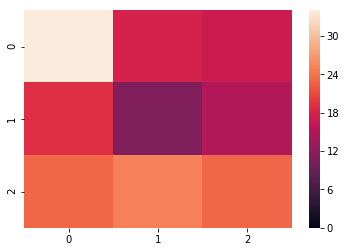

In [43]:
print(clinical_info.columns)

long_survivors = set(clinical_info[clinical_info['time'] > 2]['id'])
short_survivors = set(clinical_info[clinical_info['time'] < 1]['id'])
mid_survivors = set(clinical_info['id']) - long_survivors - short_survivors

sets = [("long", long_survivors), ("short", short_survivors), ("mid", mid_survivors)]

print(len(short_survivors) + len(long_survivors) + len(mid_survivors))
print(len(short_survivors), len(long_survivors), len(mid_survivors))


def test_positive(survs: set, df: pd.DataFrame, str_key: str):
    # print(key)
    # print(df[df['pA'].isin(survs)])
    comps = df[df['pA'].isin(survs) & (df['pB'] == str_key)]
    total = len(comps)
    count = len(comps[comps['predictions']])
    # print(total)
    # print(count)
    # print(comps[comps['predictions']])
    
    comps = df[(df['pA'] == str_key) & (df['pB'].isin(survs))]
    total += len(comps)
    count += len(comps[~comps['predictions']])
    
    return count/total


y_true = []
y_pred = []
for key, pred_df in element_predictions.items():
    # print(pred_df.columns)
    
    is_censored = not bool(clinical_info.loc[clinical_info['id'] == key, 'event'].iloc[0])
    if is_censored:
        continue
    
    for name, class_set in sets:
        if key in class_set:
            y_true.append(name)
            break
    else:
        print("Error no set found")
    
    # Test long survivability
    if not test_positive(long_survivors, pred_df, key) < 0.5:
        y_pred.append("long")
    elif not test_positive(short_survivors, pred_df, key) > 0.5:
        y_pred.append("short")
    else:
        y_pred.append("mid")


matrix: np.ndarray = confusion_matrix(y_true, y_pred, ['short', 'mid', 'long'])
sns.heatmap(matrix, vmin=0)

print(len(y_true))
print(matrix.diagonal().sum()/matrix.sum())
print(matrix)